# Imports

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('talk')
from corner import corner
from scipy import stats
from sklearn.preprocessing import StandardScaler
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.PDAG2DAG import pdag2dag
from estimate_parameters import estimate_parameters

# Data Exploration

In [16]:
filename = 'tetrad_galacticus_table_acyclic.dat'
data = np.loadtxt(filename, skiprows=1)
var_names = np.loadtxt(filename, max_rows=1, dtype=str)
print(data.shape)
print(var_names.shape)

(1460, 7)
(7,)


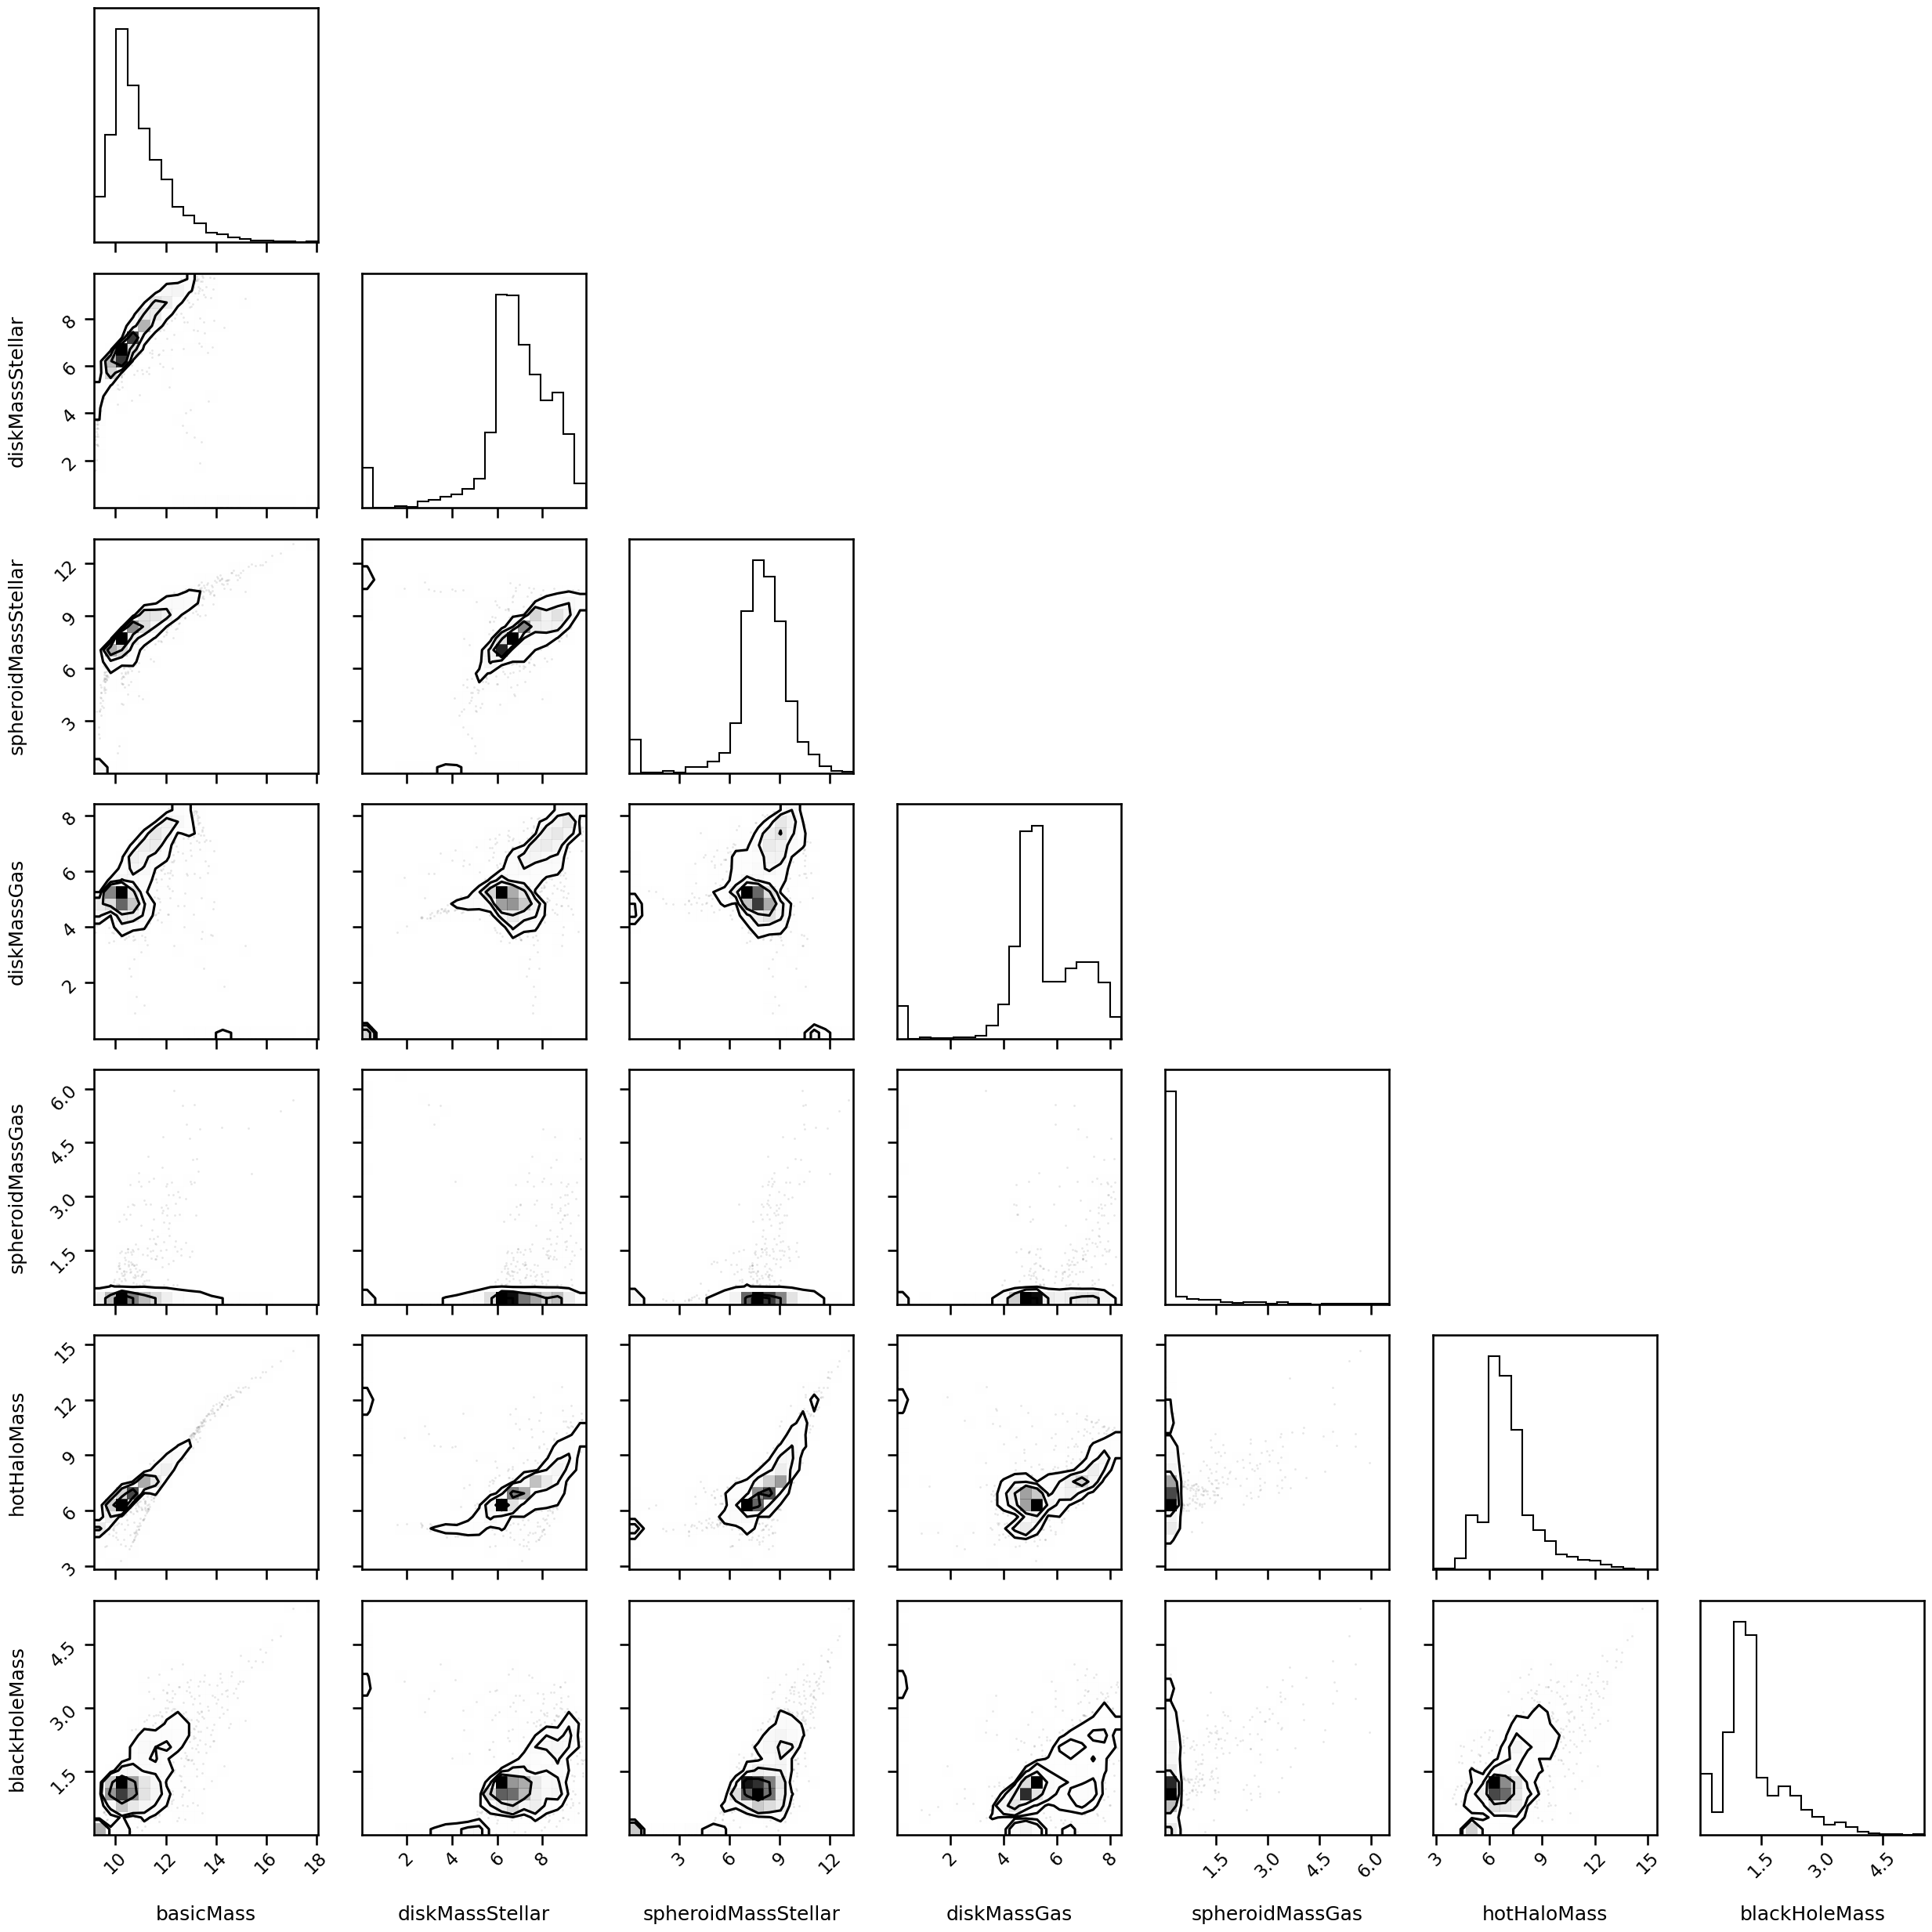

In [17]:
n = 4

# not standardized, does it need to be standardized?
fig = plt.figure(figsize=(25,25))
_ = corner(data, labels=var_names, fig=fig)

In [18]:
# standardize to check for differences later
std_data = StandardScaler().fit_transform(data)

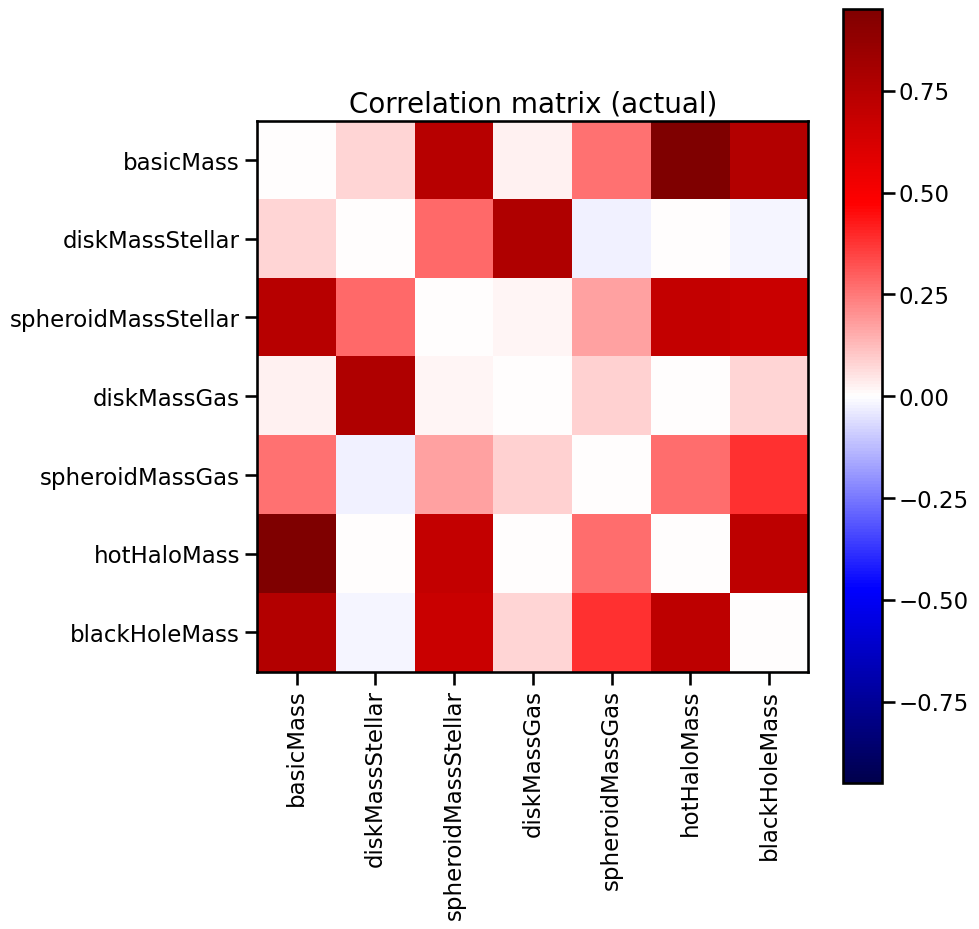

In [19]:
# showing correlation matrix, no difference when standardized
corr = np.corrcoef(data.T)
np.fill_diagonal(corr, 0)
bound = np.max(np.abs(corr))

fig = plt.figure(figsize=(10,10))
plt.imshow(corr, cmap='seismic', vmin=-bound, vmax=bound, interpolation='nearest')
plt.colorbar()
plt.xticks(range(7), var_names, rotation=90)
plt.yticks(range(7), var_names)
plt.title('Correlation matrix (actual)', fontsize=20)
plt.show()

# PC Algorithm without Subsampling

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

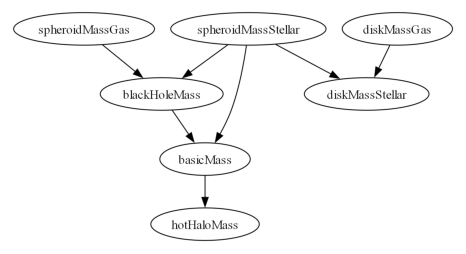

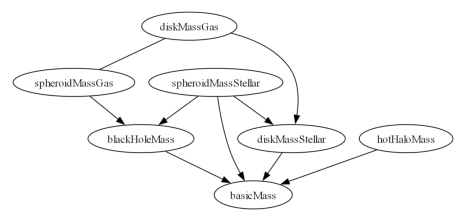

In [20]:
# initial PC testing, no subsampling, no difference when standardized
cg_01_alpha = pc(data, alpha=0.01, indep_test='fisherz')
cg_05_alpha = pc(data, alpha=0.05, indep_test='fisherz')
# std_cg_01_alpha = pc(std_data, alpha=0.01, indep_test='fisherz')
# std_cg_05_alpha = pc(std_data, alpha=0.05, indep_test='fisherz')

plt.figure(0, figsize=(5,5))
cg_01_alpha.draw_pydot_graph(labels=var_names)
plt.show()
plt.figure(1, figsize=(5,5))
cg_05_alpha.draw_pydot_graph(labels=var_names)
plt.show()
# plt.figure(2, figsize=(5,5))
# std_cg_01_alpha.draw_pydot_graph(labels=var_names)
# plt.show()
# plt.figure(3, figsize=(5,5))
# std_cg_05_alpha.draw_pydot_graph(labels=var_names)
# plt.show()

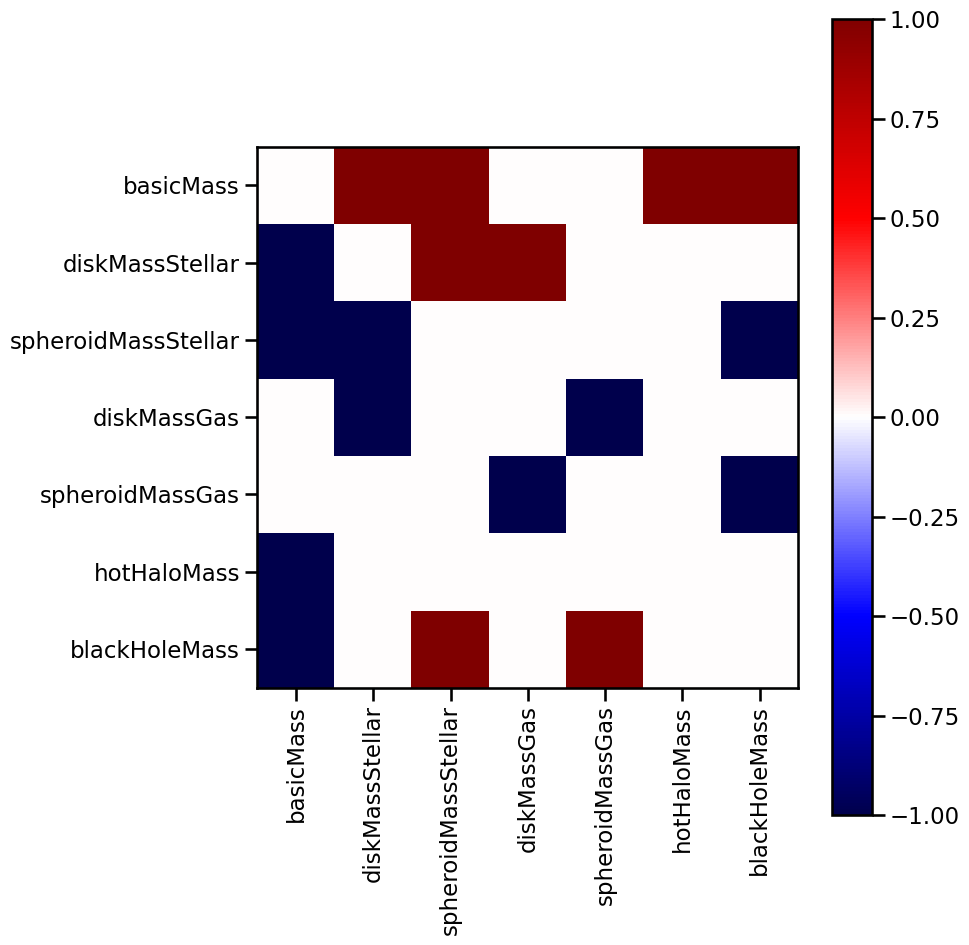

In [21]:
pdag_mat_05 = cg_05_alpha.G.graph

plt.figure(figsize=(10,10))
plt.imshow(pdag_mat_05, cmap='seismic', vmin=-1, vmax=1, interpolation='nearest')
plt.colorbar()
_ = plt.xticks(range(7), var_names, rotation=90)
_ = plt.yticks(range(7), var_names)

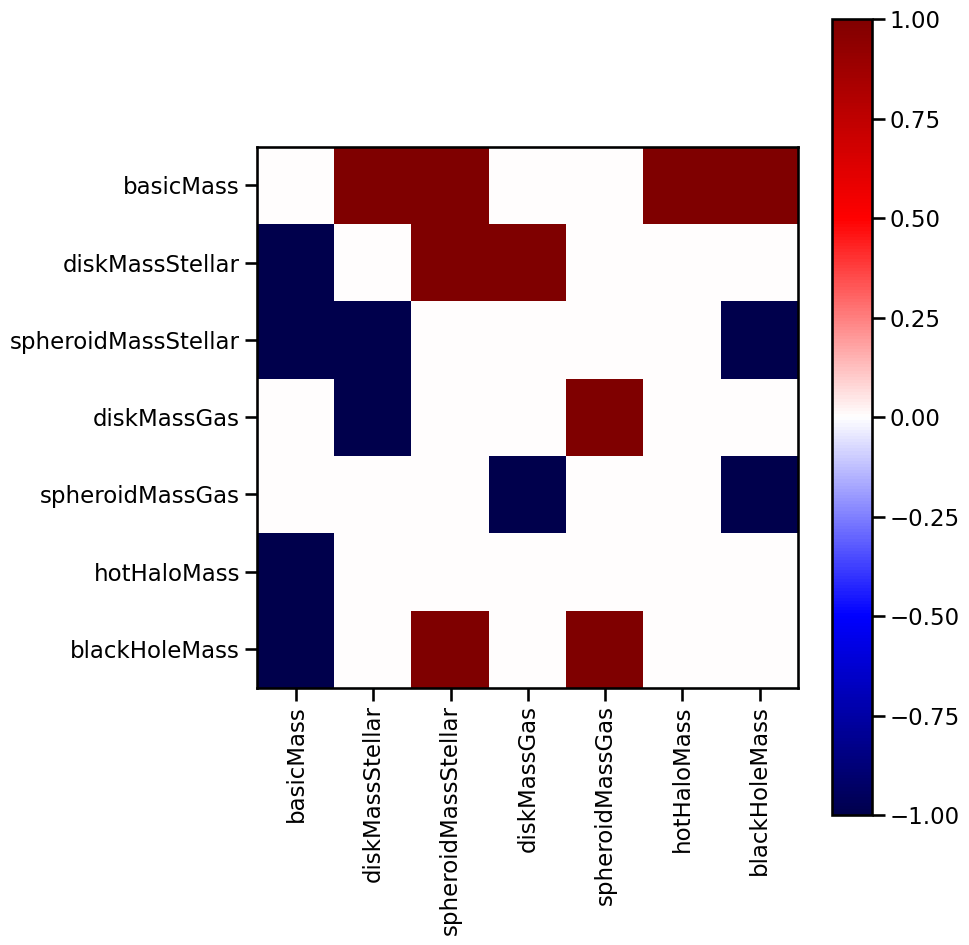

In [22]:
# convert to DAG to direct that one undirected edge and estimate weights
dag_mat_01 = pdag2dag(cg_01_alpha.G).graph
dag_mat_05 = pdag2dag(cg_05_alpha.G).graph

plt.figure(figsize=(10,10))
plt.imshow(dag_mat_05, cmap='seismic', vmin=-1, vmax=1, interpolation='nearest')
plt.colorbar()
_ = plt.xticks(range(7), var_names, rotation=90)
_ = plt.yticks(range(7), var_names)

Text(0.5, 1.0, 'Estimated weights (alpha=0.05)')

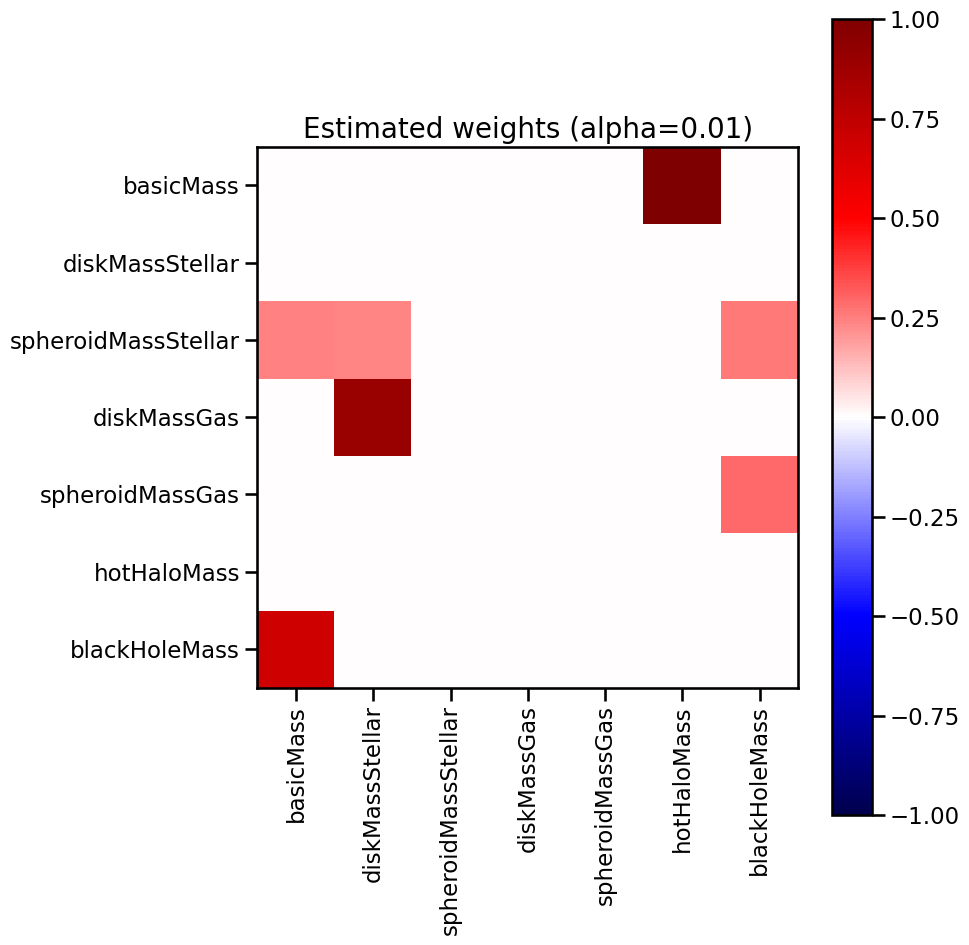

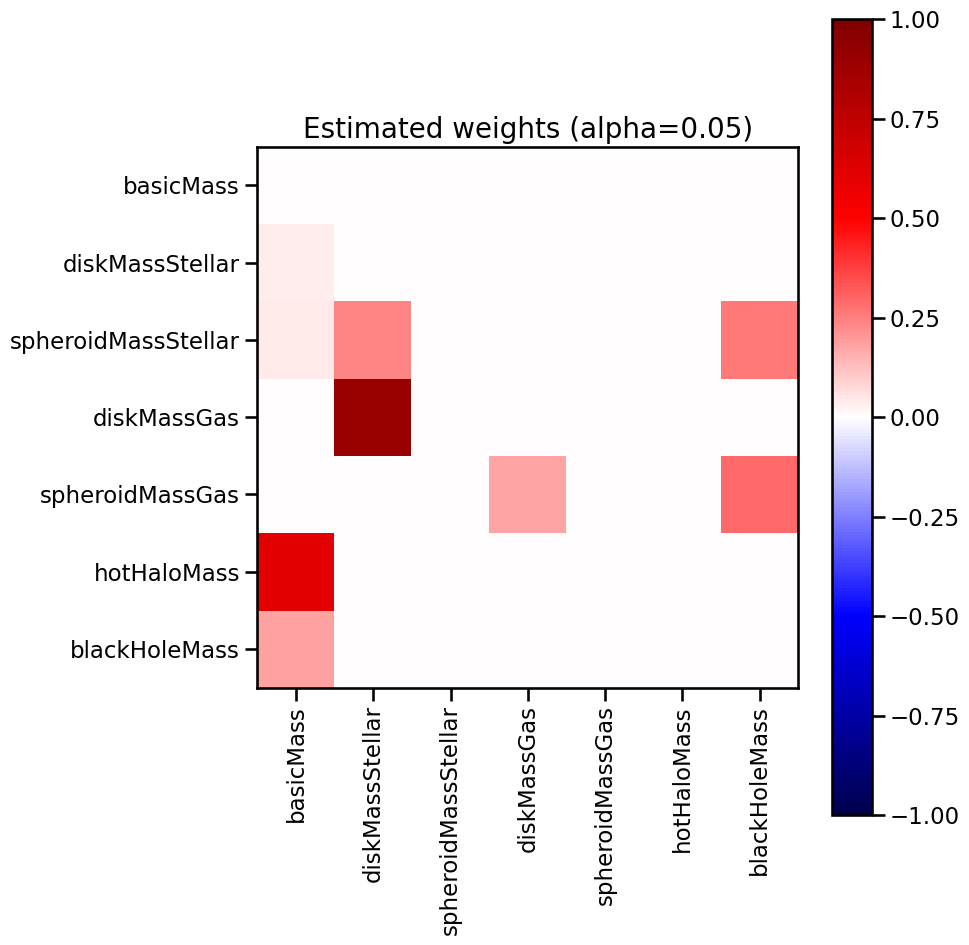

In [23]:
# estimate weights
weights_01, residuals_01 = estimate_parameters(dag_mat_01, data)
weights_05, residuals_05 = estimate_parameters(dag_mat_05, data)

plt.figure(0, figsize=(10,10))
plt.imshow(weights_01, cmap='seismic', vmin=-1, vmax=1, interpolation='nearest')
plt.colorbar()
_ = plt.xticks(range(7), var_names, rotation=90)
_ = plt.yticks(range(7), var_names)
plt.title('Estimated weights (alpha=0.01)', fontsize=20)

plt.figure(1, figsize=(10,10))
plt.imshow(weights_05, cmap='seismic', vmin=-1, vmax=1, interpolation='nearest')
plt.colorbar()
_ = plt.xticks(range(7), var_names, rotation=90)
_ = plt.yticks(range(7), var_names)
plt.title('Estimated weights (alpha=0.05)', fontsize=20)

> Note: the diskMassGas/blackHoleMass and spheroidMassGas/blackHoleMass relations have their weights in the upper triangular region which is why they do not appear in the lower triangular region

> Obervation: the graphs for the two alpha values agree on the edges between a few variables, though the basicMass/hotHaloMass edge has its direction under controversy

# PC Algorithm with Subsampling

In [ ]:
# 4 subsamples with 365 samples each - SEEDED TESTS w/ 42

np.random.seed(42)
n_samples = 365

def subsample_data(data, n_samples):
    idxs = np.arange(data.shape[0])
    np.random.shuffle(idxs)
    
    assert data.shape[0] % n_samples == 0, "length of data needs to be divisible by samples"
    subsample_idxs = np.array_split(idxs, data.shape[0] // n_samples)
    return [data[idxs] for idxs in subsample_idxs]

subsamples = subsample_data(data, n_samples)

# adjacency matrices for each subsample
adj_mats = []
for subsample in subsamples:
    cg = pc(subsample, alpha=0.05, indep_test='fisherz')
    # cg.draw_pydot_graph(labels=var_names)
    adj_mats.append(np.abs(cg.G.graph))

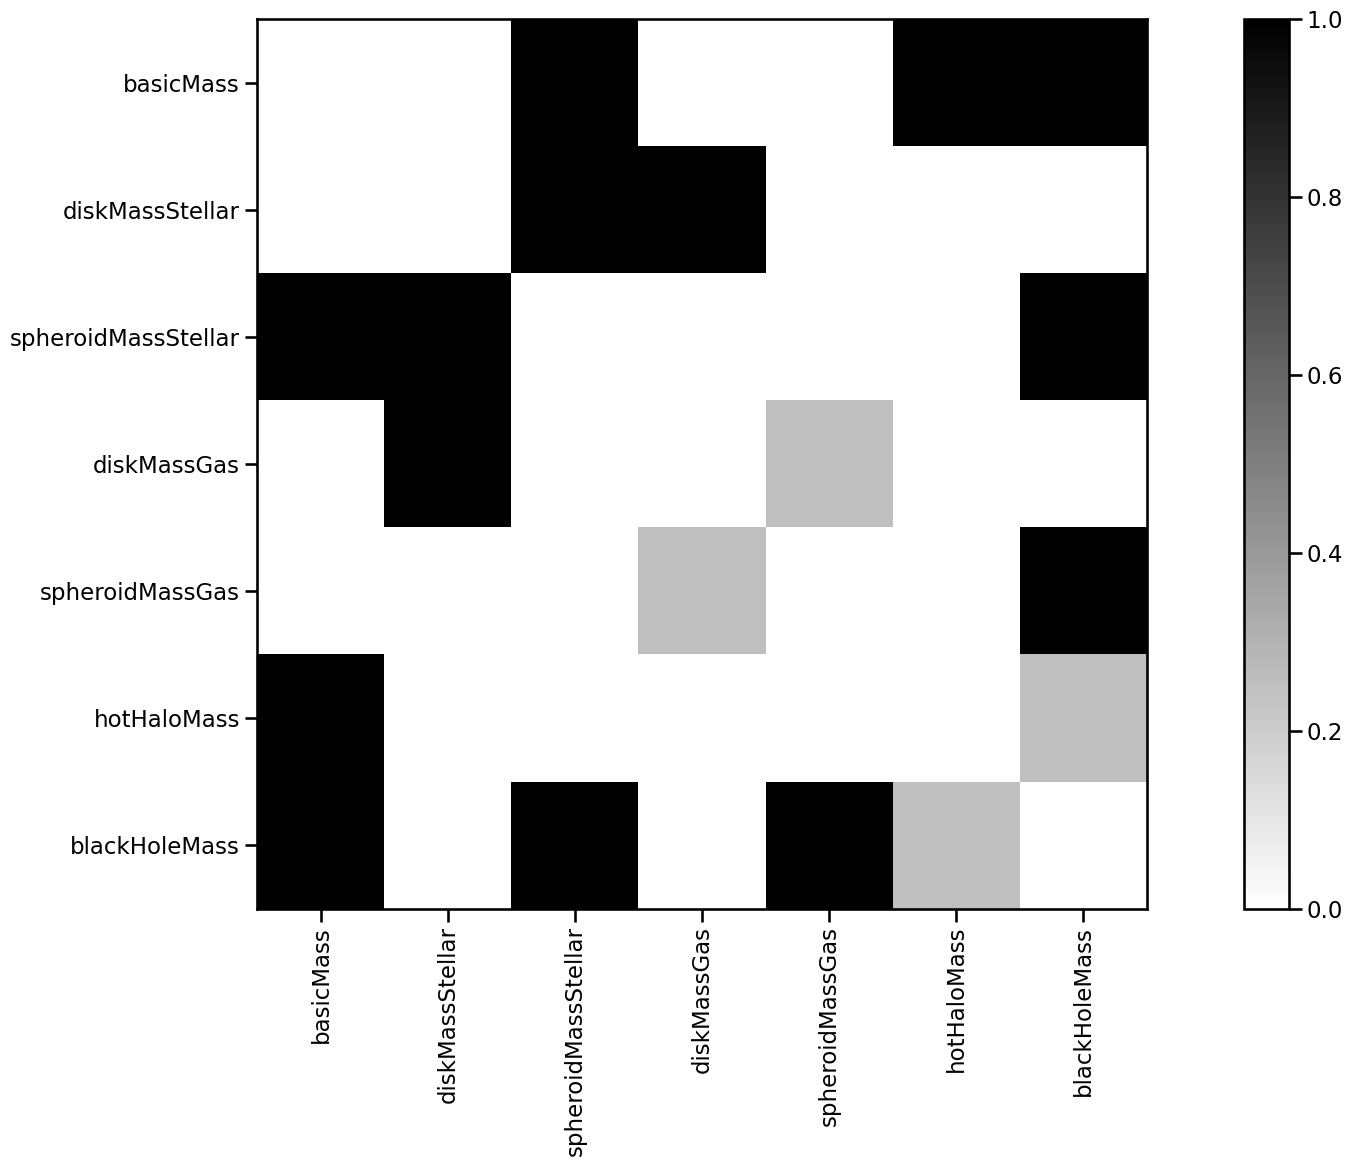

In [25]:
# average adjacency matrix
avg_adj_mat = np.mean(adj_mats, axis=0)
plt.imshow(avg_adj_mat, cmap='binary', interpolation='nearest')
plt.colorbar()
_ = plt.xticks(range(7), var_names, rotation=90)
_ = plt.yticks(range(7), var_names)

In [ ]:
# 4 subsamples with 365 samples each - AVERAGING OVER MULTIPLE RANDOM SEEDS
adj_mats = []
for i in range(5):
    np.random.seed(i*8)

    subsamples = subsample_data(data, n_samples)

    for subsample in subsamples:
        cg = pc(subsample, alpha=0.05, indep_test='fisherz')
        # cg.draw_pydot_graph(labels=var_names)
        adj_mats.append(np.abs(cg.G.graph))

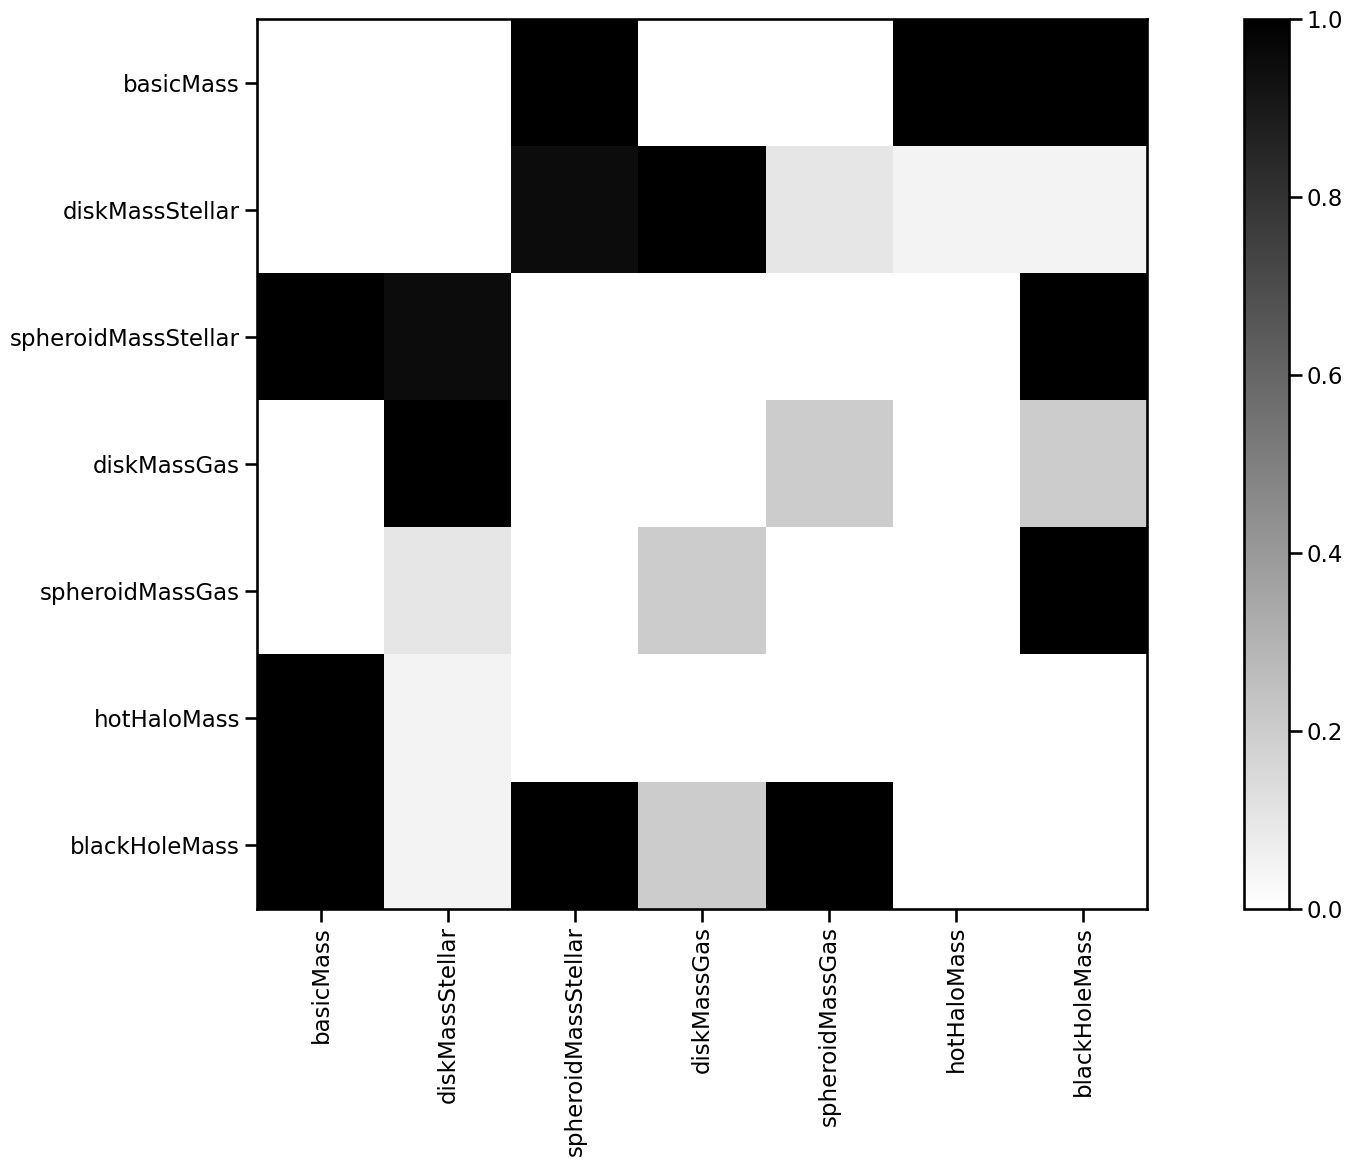

In [27]:
# average adjacency matrix
avg_adj_mat = np.mean(adj_mats, axis=0)
plt.imshow(avg_adj_mat, cmap='binary', interpolation='nearest')
plt.colorbar()
_ = plt.xticks(range(7), var_names, rotation=90)
_ = plt.yticks(range(7), var_names)

> Note: the above graph is using alpha = 0.05

> Observation: there are 7 edge in agreement between the subsamples, though further testing has to be done with different alpha values

# Varying Alpha with Subsampling

In [45]:
alphas = [0.01, 0.02, 0.05, 0.1, 0.15, 0.2]
avg_adj_mats = []

for alpha in alphas:
    adj_mats = []
    # if you need to make sure same subsamples are used for all alphas: (don't think it's necessary)
    # np.random.seed(42)
    subsamples = subsample_data(data, n_samples)

    for subsample in subsamples:
        cg = pc(subsample, alpha=alpha, indep_test='fisherz')
        # cg.draw_pydot_graph(labels=var_names)
        adj_mats.append(np.abs(cg.G.graph))

    avg_adj_mats.append(np.mean(adj_mats, axis=0))

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

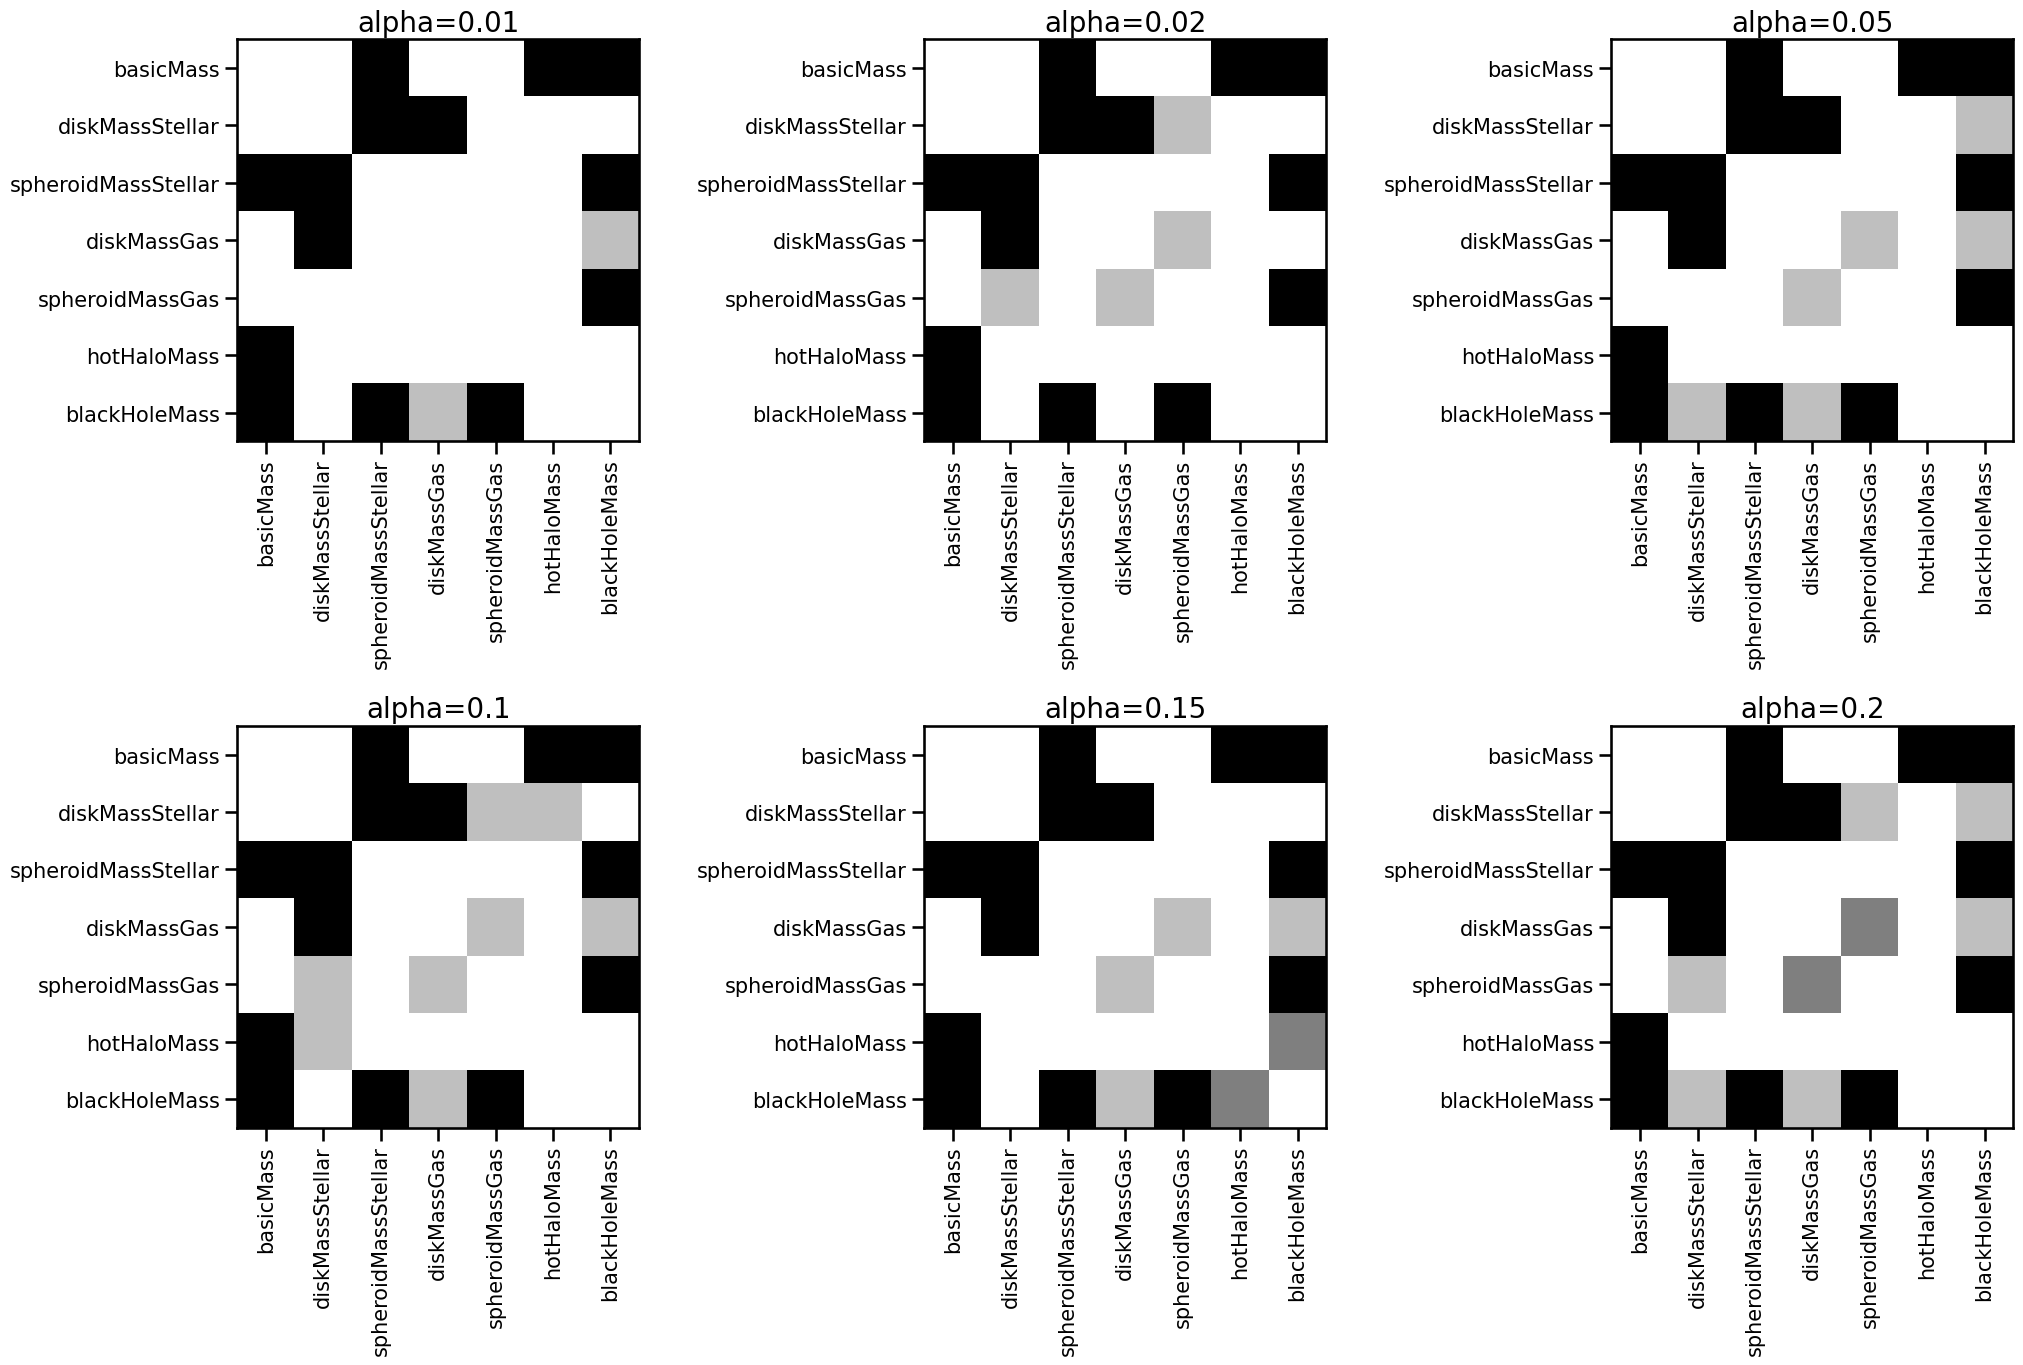

In [46]:
fig, axs = plt.subplots(2, 3, figsize=(21,14))
for i, ax in enumerate(axs.flat):
    ax.imshow(avg_adj_mats[i], cmap='binary', interpolation='nearest')
    ax.set_xticks(range(7))
    ax.set_yticks(range(7))
    ax.set_xticklabels(var_names, rotation=90, fontsize=15)
    ax.set_yticklabels(var_names, fontsize=15)
    ax.set_title(f'alpha={alphas[i]}', fontsize=20)

> Observation: there are 7 edges that are definitely existing, and 2 that could be under contention. Namely, the diskMassGas/blackHoleMass and diskMassGas/spheroidMassGas edges.

> Note: edges vary slightly between different runs (subsampling differences), but the 7 edges that are always black are always there, and the 2 under contention are as well. 